In [2]:
import scanpy as sc
import squidpy as sq

import numpy as np
import pandas as pd

adata1 = sc.read_h5ad('datasets/merfish/H18.06.006.MTG.4000.expand.rep1.h5ad')
adata2 = sc.read_h5ad('datasets/merfish/H18.06.006.MTG.4000.expand.rep2.h5ad')
adata3 = sc.read_h5ad('datasets/merfish/H18.06.006.MTG.4000.expand.rep3.h5ad')
adata1.obs['batch'] = 'H18.06.006.MTG.4000.rep1'
adata2.obs['batch'] = 'H18.06.006.MTG.4000.rep2'
adata3.obs['batch'] = 'H18.06.006.MTG.4000.rep3'

adata1.obs['coord'] = adata1.obsm['spatial'][:,1]
adata1.obs['niche'] = 'N1'
adata1.obs['niche'][adata1.obs['coord']> -1500] = 'N2'
adata1.obs['niche'][adata1.obs['coord']> -1000] = 'N3'
adata1.obs['niche'][adata1.obs['coord']> -200] = 'N4'
adata1.obs['niche'][adata1.obs['coord']> 350] = 'N5'

adata2.obs['coord'] = np.sqrt((adata2.obsm['spatial'][:,0]+3000) ** 2 + (adata2.obsm['spatial'][:,1]-400) ** 2)
adata2.obs['niche'] = 'N6'
adata2.obs['niche'][adata2.obs['coord']> 2100] = 'N5'
adata2.obs['niche'][adata2.obs['coord']> 3600] = 'N4'

adata3.obs['coord'] = np.sqrt((adata3.obsm['spatial'][:,0]-3000) ** 2 + (adata3.obsm['spatial'][:,1]-1300) ** 2)
adata3.obs['niche'] = 'N6'
adata3.obs['niche'][adata3.obs['coord']> 2000] = 'N5'
adata3.obs['niche'][adata3.obs['coord']> 3900] = 'N4'
adata3.obs['niche'][adata3.obs['coord']> 4350] = 'N3'
adata3.obs['niche'][adata3.obs['coord']> 5600] = 'N2'
adata3.obs['niche'][adata3.obs['coord']> 6000] = 'N1'

adata_mtg = sc.concat([adata1,adata2,adata3])
adata_mtg.obs_names_make_unique()
adata_mtg

/tmp/ipykernel_280/4036491463.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata1.obs['niche'][adata1.obs['coord']> -1500] = 'N2'
/tmp/ipykernel_280/4036491463.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata1.obs['niche'][adata1.obs['coord']> -1000] = 'N3'
/tmp/ipykernel_280/4036491463.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata1.obs['niche'][adata1.obs['coord']> -200] = 'N4'
/tmp/ipykernel_280/4036491

AnnData object with n_obs × n_vars = 11059 × 4000
    obs: 'name', 'global.x', 'global.y', 'adjusted.x', 'adjusted.y', 'fov.x', 'fov.y', 'cluster_L1', 'cluster_L2', 'cluster_L3', 'batch', 'coord', 'niche'
    obsm: 'spatial'

In [7]:
S = np.load('Bio_results/MTG/S.npy')
adata_mtg_ = adata_mtg.copy()
sc.pp.normalize_total(adata_mtg_)
sc.pp.log1p(adata_mtg_)
sc.pp.highly_variable_genes(adata_mtg_,n_top_genes=1000)
adata_mtg_ = adata_mtg_[:,adata_mtg_.var['means']>0.1]

adata_mtg_.obsm['S'] = S.copy()
adata_mtg_.obsm['scvi'] = sc.read_h5ad('mtg_baselines2.h5ad').obsm['scvi_0']

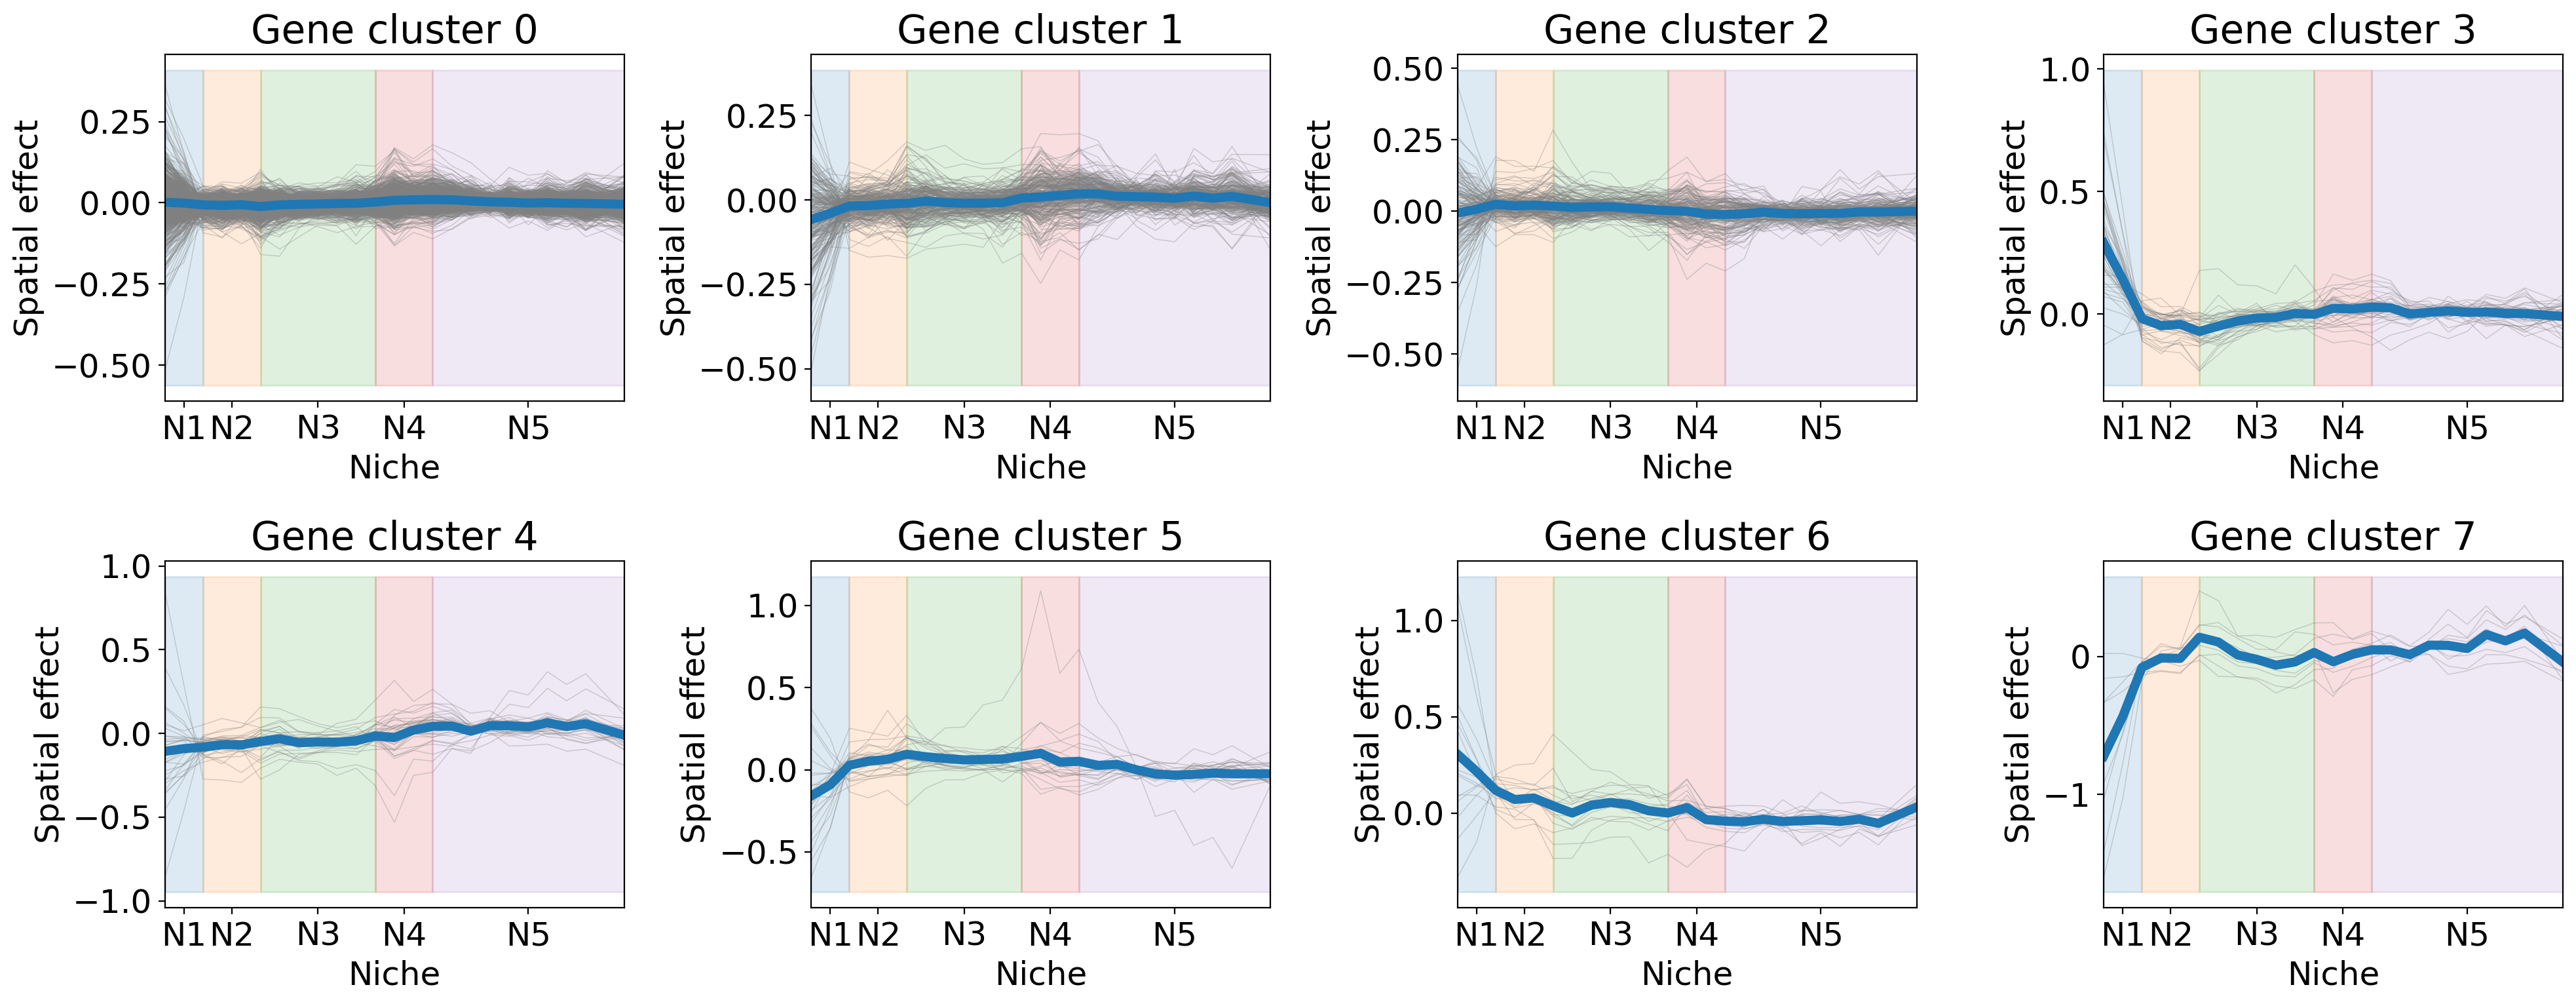

In [45]:
adata_mtg_se = sc.read_h5ad('Bio_results/MTG/mtg_se.h5ad')
adata_mtg.obsm['simvi_z'] = adata_mtg_.obsm['scvi'].copy()
adata_mtg.obsm['simvi_s'] = adata_mtg_se.obsm['simvi_s']
from simvi.model import SimVI
SimVI.setup_anndata(adata_mtg,batch_key='batch')
edge_index = SimVI.extract_edge_index(adata_mtg,n_neighbors=10,batch_key='batch')
from pytorch_lightning.utilities.seed import seed_everything
seed_everything(0)
model = SimVI(adata_mtg,kl_weight=1,kl_gatweight=0.01,lam_mi=1000,permutation_rate=0.5,n_spatial=20,n_intrinsic=20)
se, r2_z, r2_s, r2_zpv, r2_spv, S = model.get_se(edge_index,adata=adata_mtg,num_arch =7, Kfold=1,cell_type_label='cluster_L2')

se = np.sum(se,axis=0)

from scipy.stats import kendalltau
from scipy.stats import spearmanr
from sklearn.neighbors import kneighbors_graph


adata_mtg_c1 = adata_mtg_.copy()
adata_mtg_c1.X = se[:,adata_mtg.var_names.isin(adata_mtg_.var_names)]
adata_mtg_c1 = adata_mtg_c1[adata_mtg_c1.obs['batch']==adata_mtg.obs['batch'].unique()[0]].copy()
adata_mtg_c1 = adata_mtg_c1[adata_mtg_c1.obs['cluster_L1']=='lASC']



sp_c2 = np.zeros(adata_mtg_c1.shape[1])
kt_c2 = np.zeros(adata_mtg_c1.shape[1])
j = 0
for source_row in adata_mtg_c1.X.T:
    sp_c2[j], pv = spearmanr(source_row, adata_mtg_c1.obsm['spatial'][:,1])
    kt_c2[j], pv = kendalltau(source_row, adata_mtg_c1.obsm['spatial'][:,1])
    j = j + 1
kt_c2 = np.abs(kt_c2)
sp_c2 = np.abs(sp_c2)

df = pd.DataFrame(adata_mtg_c1.X,columns = adata_mtg_.var_names)
df['x'] = adata_mtg_c1.obsm['spatial'][:,1]

bins = np.linspace(df['x'].min(), df['x'].max(), 26)


df['bin'] = pd.cut(df['x'], bins=bins, include_lowest=True, labels=range(25))


bin_means = df.groupby('bin').mean().dropna()
bin_means = bin_means.iloc[:,:-1]
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams["font.size"] = 18
fig, axes = plt.subplots(2,4,figsize=(20,8))
c_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
j = 0
k = 0
for i in range(8):
    axes[j,k].plot(bin_means.index.astype(int),bin_means.loc[:,sp_df['kmeans']==i].values,color='gray',linewidth=0.5,alpha=0.35)
    axes[j,k].plot(bin_means.index.astype(int),np.mean(bin_means.loc[:,sp_df['kmeans']==i].values,axis=1),linewidth=5)
    axes[j,k].set_xlabel('Niche')
    
    custom_ticks = [1, 3.5,8,12.5,19]
    custom_labels = ['N1','N2','N3','N4','N5']
    axes[j,k].set_xticks(custom_ticks, custom_labels)
    axes[j,k].set_ylabel('Spatial effect')
    axes[j,k].set_xlim((0,24))
    axes[j,k].set_title('Gene cluster '+str(i))
    x = bin_means.index.astype(int)
    y = axes[j,k].get_ylim()
    axes[j,k].fill_between(bin_means.index.astype(int), y[1],y[0], where=(x <= 2), color=c_list[0], alpha=0.15)
    axes[j,k].fill_between(bin_means.index.astype(int), y[1],y[0], where=(x >= 2) & (x <= 5), color=c_list[1], alpha=0.15)
    axes[j,k].fill_between(bin_means.index.astype(int), y[1],y[0], where=(x >= 5) & (x <= 11), color=c_list[2], alpha=0.15)
    axes[j,k].fill_between(bin_means.index.astype(int), y[1],y[0], where=(x >= 11) & (x <= 14), color=c_list[3], alpha=0.15)
    axes[j,k].fill_between(bin_means.index.astype(int), y[1],y[0], where=(x >= 14) & (x <= 24), color=c_list[4], alpha=0.15)
    k = k + 1
    if k > 3:
        k = 0
        j = 1
        
        
plt.tight_layout()
plt.savefig('figures/mtg_ASC_scviablation.pdf',bbox_inches='tight')

In [49]:
sp_c2 = np.zeros(adata_mtg_c1.shape[1])
kt_c2 = np.zeros(adata_mtg_c1.shape[1])
j = 0
for source_row in adata_mtg_c1.X.T:
    sp_c2[j], pv = spearmanr(source_row, adata_mtg_c1.obsm['spatial'][:,0])
    kt_c2[j], pv = kendalltau(source_row, adata_mtg_c1.obsm['spatial'][:,0])
    j = j + 1
kt_c2 = np.abs(kt_c2)
sp_c2 = np.abs(sp_c2)

In [50]:
sp_df2 = pd.read_csv('Benchmarking_results/mtg_se_asc_sp_x.csv',index_col=0)
kt_df2 = pd.read_csv('Benchmarking_results/mtg_se_asc_kt_x.csv',index_col=0)
sp_df2['scvi_arch'] = sp_c2
kt_df2['scvi_arch'] = kt_c2

In [39]:
## changed above calculation with adata_mtg_c1.obsm['spatial'][:,0]

sp_df = pd.read_csv('Benchmarking_results/mtg_se_asc_sp.csv',index_col=0)
kt_df = pd.read_csv('Benchmarking_results/mtg_se_asc_kt.csv',index_col=0)
sp_df['scvi_arch'] = sp_c2
kt_df['scvi_arch'] = kt_c2

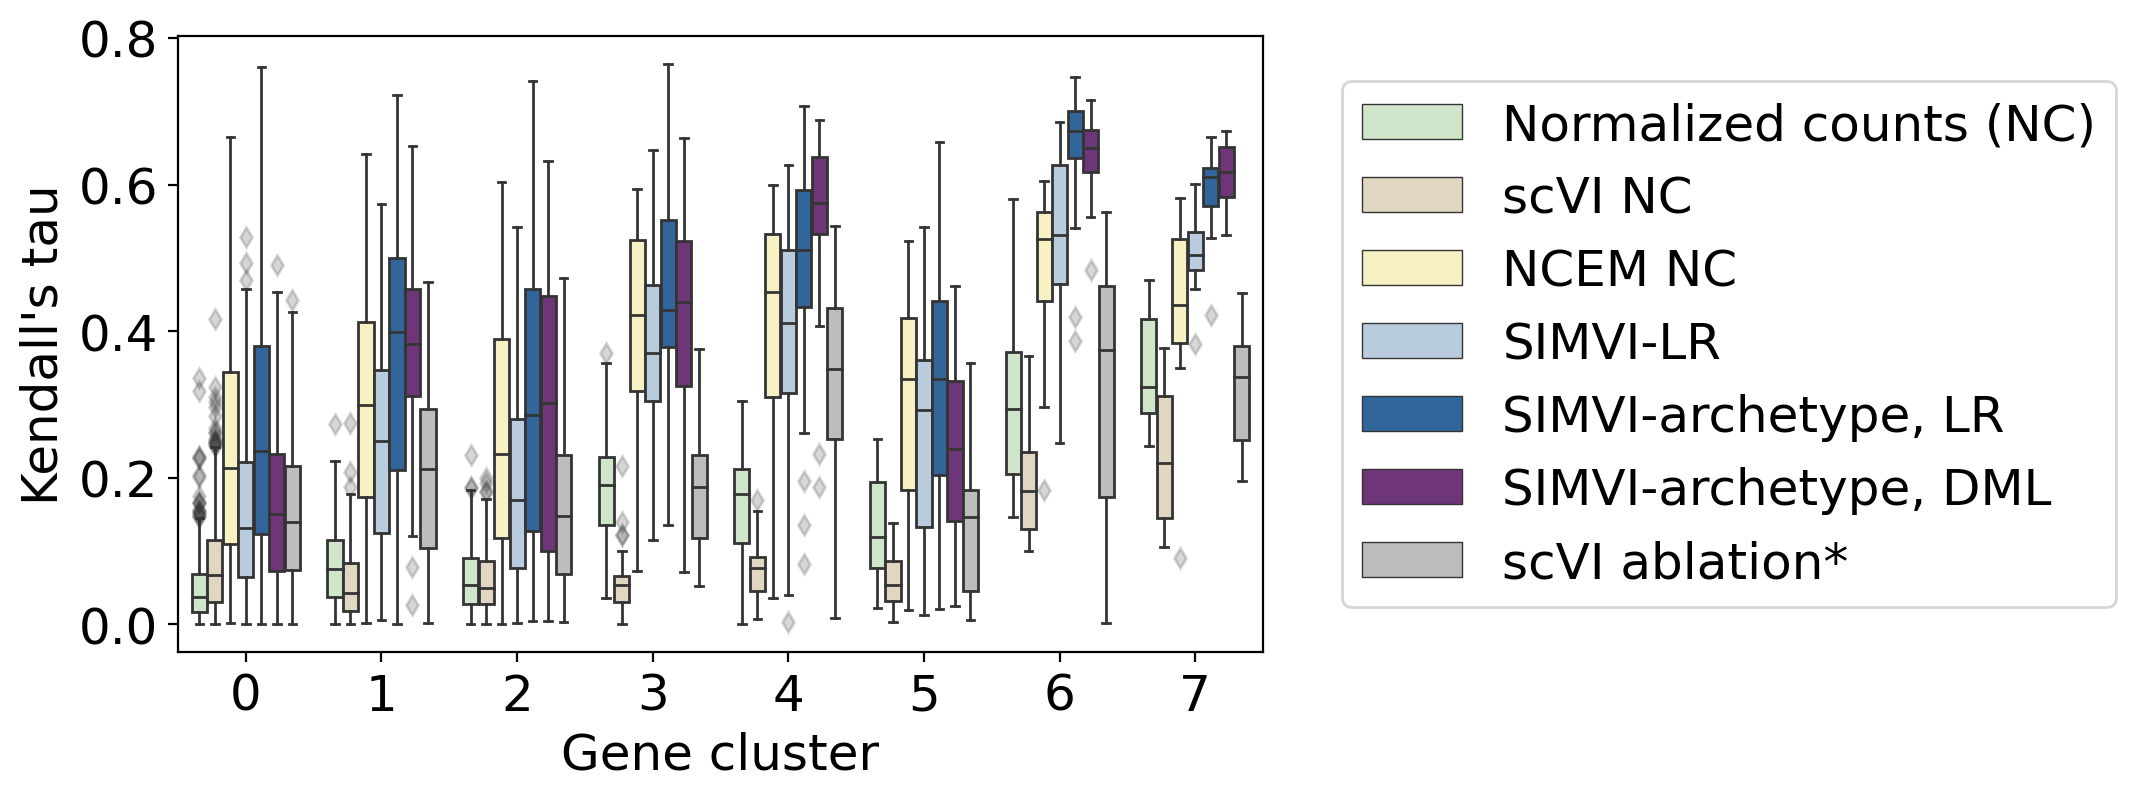

In [81]:
import seaborn as sns

fig = plt.figure(figsize=(7,4))

plte = ['#ccebc5','#e5d8bd','#fff7bc','#b3cde3','#2166ac','#762a83','#bdbdbd']

df_ = kt_df.copy()
df_.columns = ['Normalized counts (NC)','scVI NC','k-NN','SIMVI-archetype, DML','kmeans','NCEM NC','cside','cside (arch)','SIMVI-archetype, LR','SIMVI-LR','scVI ablation*']

sns.boxplot(data=pd.melt(df_, var_name='Methods', value_name="Kendall's tau",ignore_index=False,id_vars=['kmeans']),hue='Methods',y="Kendall's tau",x='kmeans',hue_order=['Normalized counts (NC)','scVI NC','NCEM NC','SIMVI-LR','SIMVI-archetype, LR','SIMVI-archetype, DML','scVI ablation*'],order=[0,1,2,3,4,5,6,7],palette=plte,flierprops={'alpha': 0.2},linewidth=1)

plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.xlabel('Gene cluster')

plt.savefig('figures/mtg_kt_y_full.pdf',bbox_inches='tight')

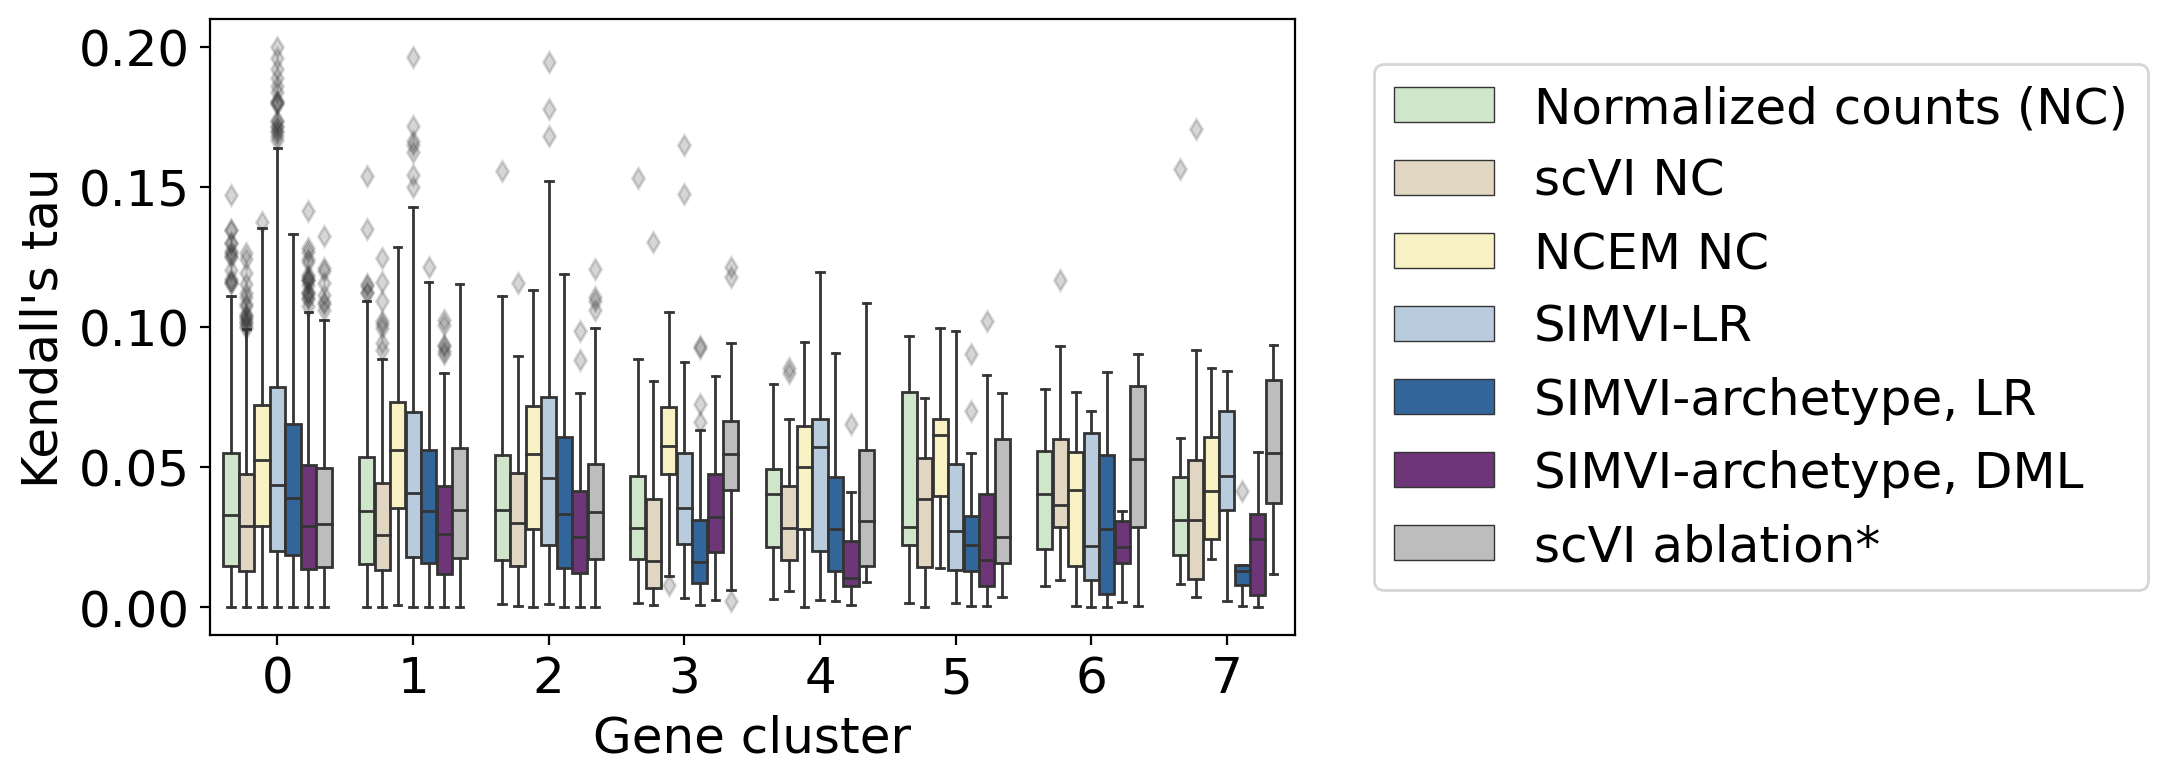

In [79]:
import seaborn as sns

fig = plt.figure(figsize=(7,4))

plte = ['#ccebc5','#e5d8bd','#fff7bc','#b3cde3','#2166ac','#762a83','#bdbdbd']

df_ = kt_df2.copy()
df_.columns = ['Normalized counts (NC)','scVI NC','NCEM NC','k-NN','SIMVI-archetype, DML','kmeans','cside','cside (arch)','SIMVI-archetype, LR','SIMVI-LR','scVI ablation*']

sns.boxplot(data=pd.melt(df_, var_name='Methods', value_name="Kendall's tau",ignore_index=False,id_vars=['kmeans']),hue='Methods',y="Kendall's tau",x='kmeans',hue_order=['Normalized counts (NC)','scVI NC','NCEM NC','SIMVI-LR','SIMVI-archetype, LR','SIMVI-archetype, DML','scVI ablation*'],order=[0,1,2,3,4,5,6,7],palette=plte,flierprops={'alpha': 0.2},linewidth=1)

plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.xlabel('Gene cluster')

plt.savefig('figures/mtg_kt_x_full.pdf',bbox_inches='tight')

In [2]:
r2_z = np.load('Bio_results/MTG/r2_z.npy')
r2_s = np.load('Bio_results/MTG/r2_s.npy')

In [6]:
adata_mtg.varm['r2_z'] = r2_z.T
adata_mtg.varm['r2_s'] = r2_s.T

adata_mtg_ = adata_mtg.copy()
sc.pp.normalize_total(adata_mtg_)
sc.pp.log1p(adata_mtg_)
sc.pp.highly_variable_genes(adata_mtg_,n_top_genes=1000)
adata_mtg_ = adata_mtg_[:,adata_mtg_.var['means']>0.1]
adata_mtg_

View of AnnData object with n_obs × n_vars = 11059 × 1561
    obs: 'name', 'global.x', 'global.y', 'adjusted.x', 'adjusted.y', 'fov.x', 'fov.y', 'cluster_L1', 'cluster_L2', 'cluster_L3', 'batch', 'coord', 'niche'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'
    varm: 'r2_z', 'r2_s'

/tmp/ipykernel_2181284/184159264.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_mtg_.var['class'][adata_mtg_.var['r2_z_']>0.6] = 'Cell-type specific'
/tmp/ipykernel_2181284/184159264.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_mtg_.var['class'][np.abs(adata_mtg_.var['r2_s_'].values - hr.predict(adata_mtg_.var['r2_z_'].values.reshape(-1,1)) ) / hr.scale_ > 10] = 'Spatial-induced'
/tmp/ipykernel_2181284/184159264.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

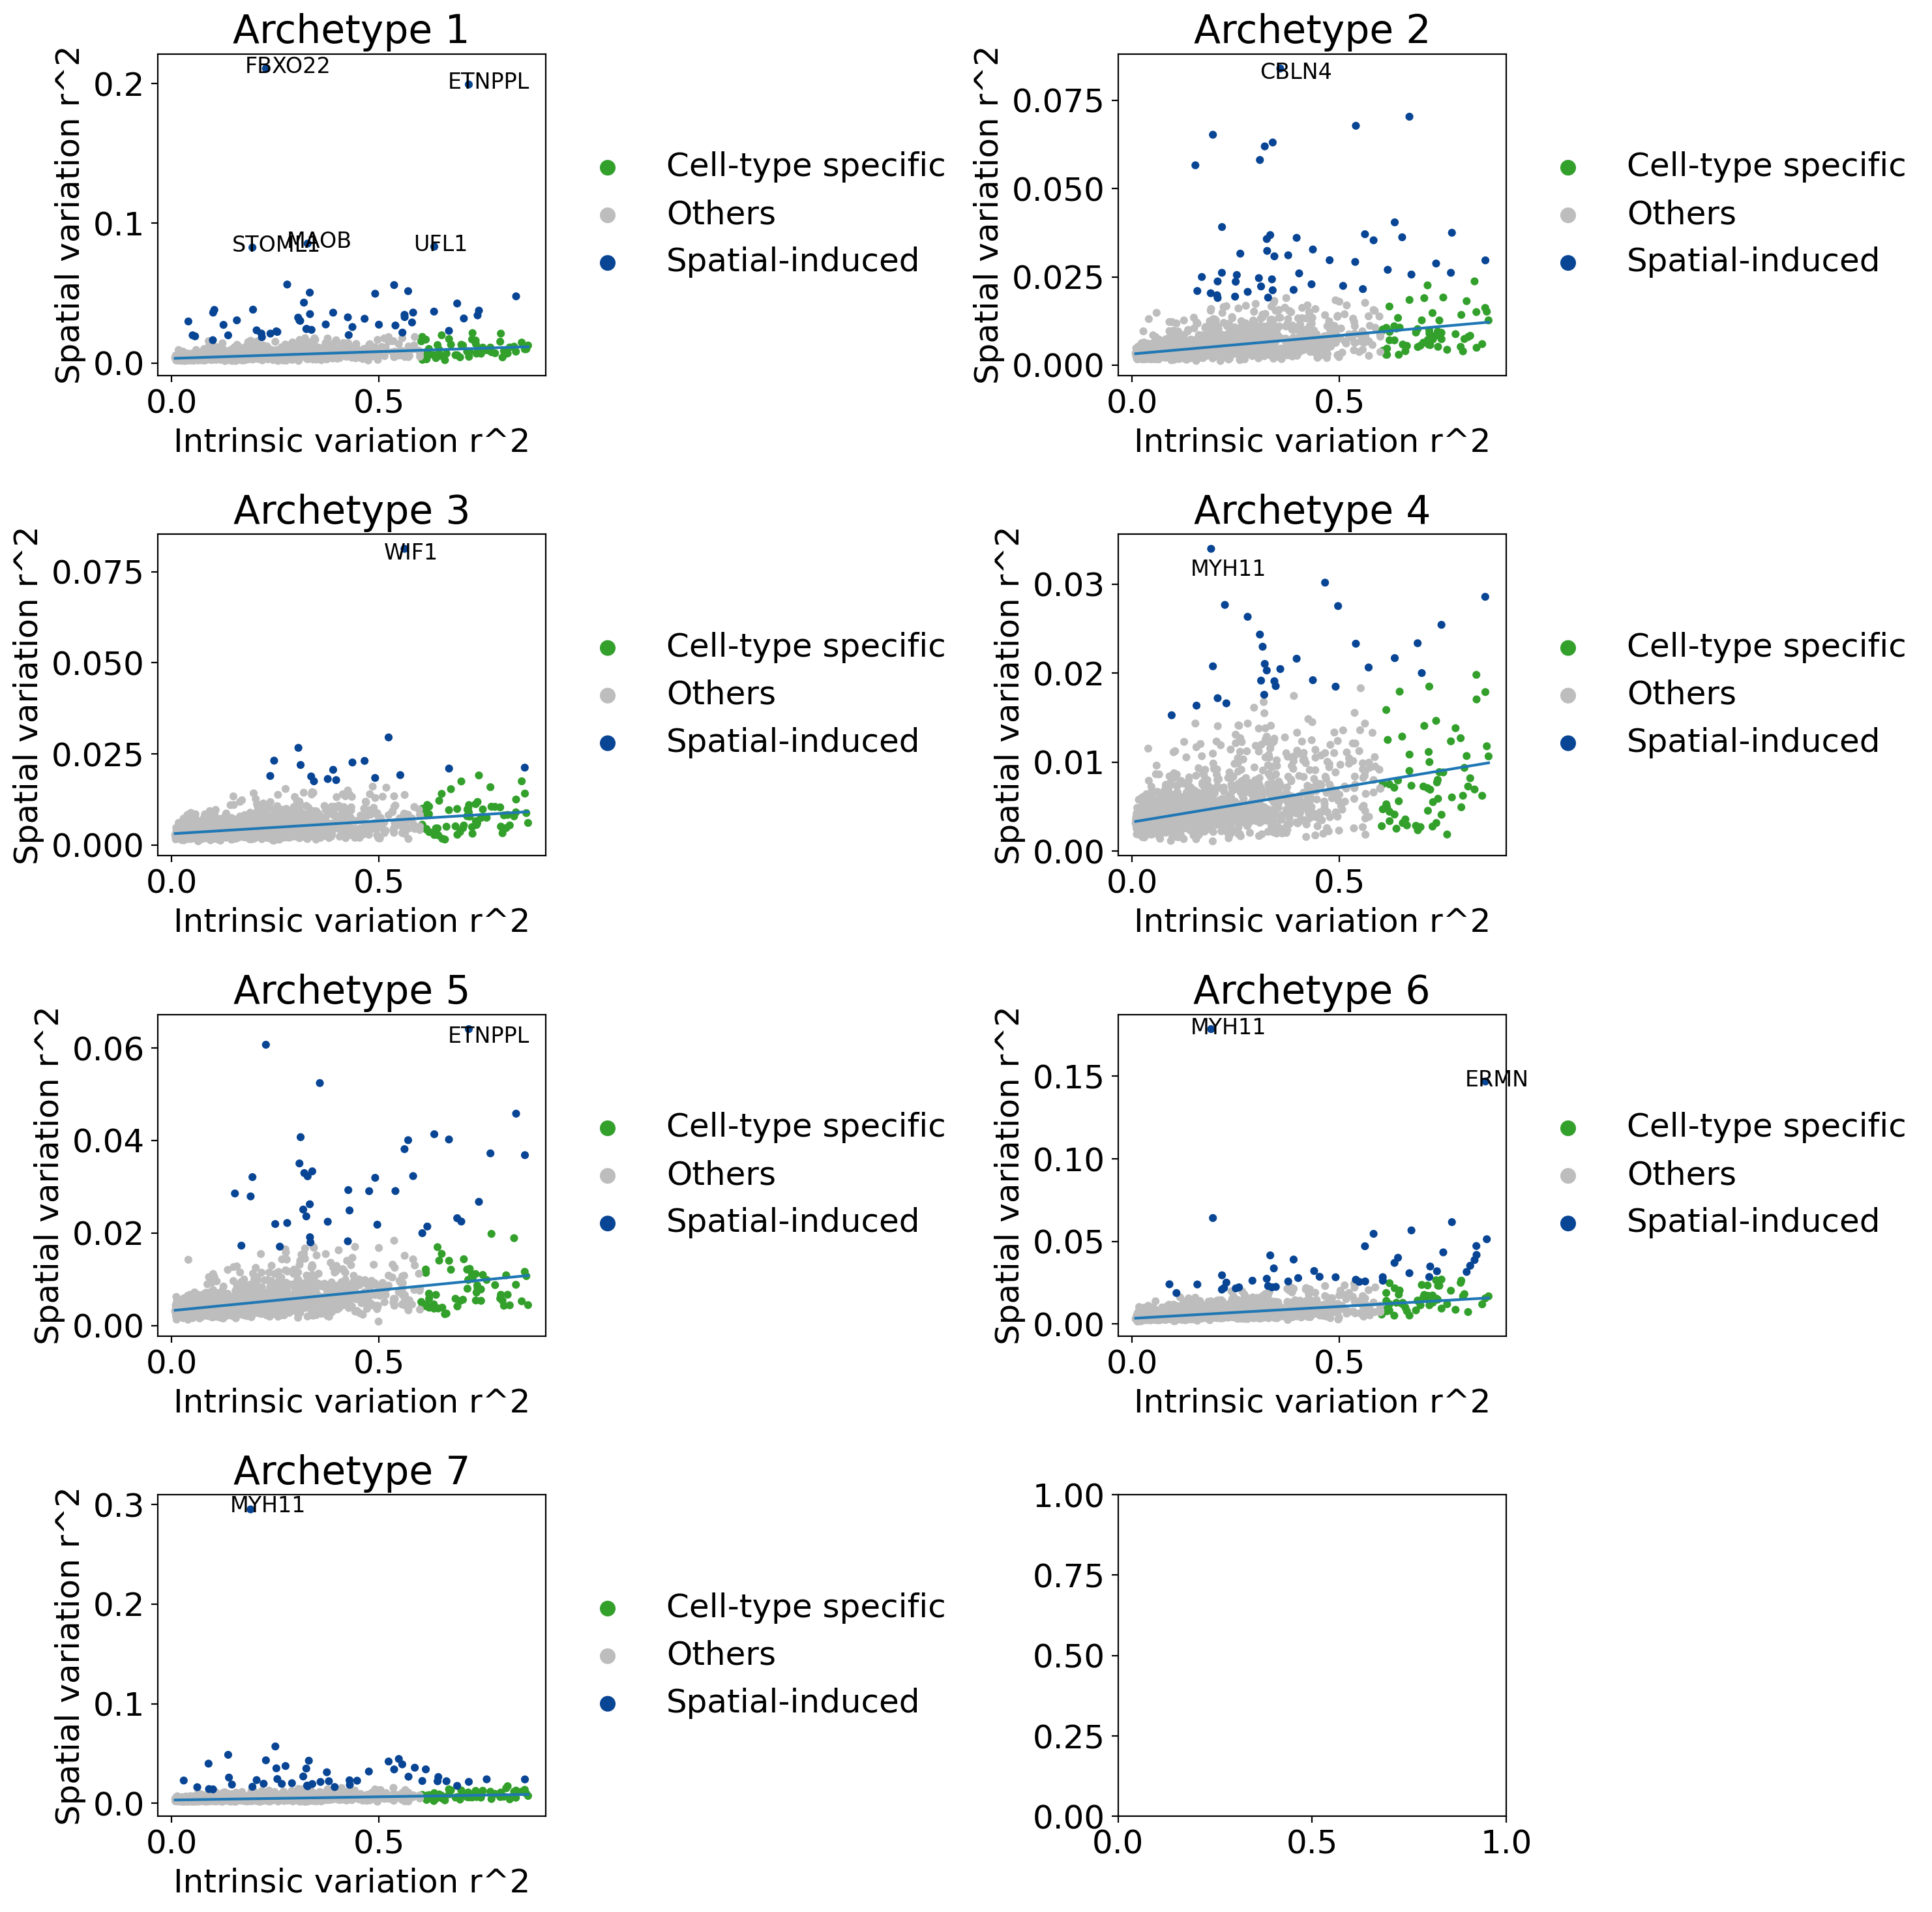

In [33]:
from sklearn.linear_model import HuberRegressor
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams["font.size"] = 18



fig, ax = plt.subplots(4,2,figsize=(15,15))
m = 0
n = 0
k = 1
for j in [1,0,2,4,6,3,5]:
    adata_mtg_.var['r2_z_'] = adata_mtg_.varm['r2_z'][:,j].copy()
    adata_mtg_.var['r2_s_'] = adata_mtg_.varm['r2_s'][:,j].copy()
    
    hr = HuberRegressor()
    hr.fit(adata_mtg_.var['r2_z_'].values.reshape(-1,1),adata_mtg_.var['r2_s_'])


    adata_mtg_.var['class'] = 'Others'

    adata_mtg_.var['class'][adata_mtg_.var['r2_z_']>0.6] = 'Cell-type specific'
    adata_mtg_.var['class'][np.abs(adata_mtg_.var['r2_s_'].values - hr.predict(adata_mtg_.var['r2_z_'].values.reshape(-1,1)) ) / hr.scale_ > 10] = 'Spatial-induced'

    adata_mtg_.uns['class_colors'] = ['#33a02c','#bdbdbd','#084594']



    sc.pl.scatter(adata_mtg_.copy(),x='r2_z_',y='r2_s_',show=False,color='class',ax=ax[n,m])
    ax[n,m].plot(adata_mtg_.var['r2_z_'].values[np.argsort(adata_mtg_.var['r2_z_'].values)],hr.predict(adata_mtg_.var['r2_z_'].values.reshape(-1,1))[np.argsort(adata_mtg_.var['r2_z_'].values)])

    for i in range(adata_mtg_.var['r2_s_'].shape[0]):
        if adata_mtg_.var['r2_s_'][i] > 0.082 or adata_mtg_.var['r2_s_'][i] == np.max(adata_mtg_.var['r2_s_']):
            ax[n,m].text(adata_mtg_.var['r2_z_'][i]-0.05,adata_mtg_.var['r2_s_'][i]-0.003,adata_mtg_.var_names[i],fontsize=12)
        
    ax[n,m].set_xlabel('Intrinsic variation r^2')
    ax[n,m].set_ylabel('Spatial variation r^2')
    ax[n,m].set_title('Archetype '+str(k))
    m = m + 1
    k = k + 1
    if m > 1:
        m = 0
        n = n + 1
        
plt.tight_layout()
plt.savefig('figures/mtg_r2_scatter_individualarch.pdf',bbox_inches='tight')